In [1]:
import torch
import matplotlib.pyplot as plt
import torch_geometric as pyg
import seaborn as sns
from GD_Unroll import GD_Block, GD_Unroll

/Users/sofiaperez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Unrolling Gradient Descent

### Forward pass with few nodes

In [2]:
num_nodes = 6
n_components = 2 

n = [num_nodes/2, num_nodes/2]
p = [[0.3, 0.1], [0.1, 0.7]]

edge_index = pyg.utils.stochastic_blockmodel_graph(n, p)

x = torch.rand((1,num_nodes,2))

data = pyg.data.Data(x = x, edge_index = edge_index)

#### Full model

In [3]:
## 1 layer = 1 step
gd_steps = 1
in_channels = 2
out_channels = 2
alpha=0.0001

model = GD_Block(in_channels, out_channels)

model.gcn.lins[0].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha

model.gat.lin1.weight.data = torch.Tensor([[0.0, 0.0], [0.0, 0.0]])
model.gat.lin2.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha
model.gat.lin3.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gat.lin4.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

with torch.no_grad():
    x_emb = model(data.x, data.edge_index, edge_index_2)

x_emb

tensor([[[0.8521, 0.9896],
         [0.3802, 0.6284],
         [0.4174, 0.9951],
         [0.8397, 0.7582],
         [0.0722, 0.2922],
         [0.7457, 0.5978]]])

In [4]:
## Gradient descent 1 step


x_new = data.x.squeeze(0)

grad_f=4*(x_new@x_new.T-pyg.utils.to_dense_adj(edge_index).squeeze())@x_new
x_new=x_new-alpha*grad_f
x_new

tensor([[0.8521, 0.9896],
        [0.3802, 0.6284],
        [0.4174, 0.9951],
        [0.8397, 0.7582],
        [0.0722, 0.2922],
        [0.7457, 0.5978]])

In [5]:
## 1000 layers == 1000 gd steps

gd_steps = 1000
in_channels = 2
out_channels = 2
alpha = 0.0001

model = GD_Unroll(in_channels, out_channels, gd_steps)

model.gd.gcn.lins[0].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha

model.gd.gat.lin1.weight.data = torch.Tensor([[0.0, 0.0], [0.0, 0.0]])
model.gd.gat.lin2.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha
model.gd.gat.lin3.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gat.lin4.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

with torch.no_grad():
    x_emb  = model(data.x , data.edge_index, edge_index_2)

x_emb

tensor([[[0.3114, 0.3376],
         [0.0853, 0.2609],
         [0.1924, 0.6180],
         [0.6007, 0.5824],
         [0.1530, 0.3030],
         [0.5362, 0.2884]]])

In [6]:
x_new=data.x.squeeze(0)

for i in range(1000):
    grad_f=4*(x_new@x_new.T-pyg.utils.to_dense_adj(edge_index).squeeze())@x_new
    x_new=x_new-alpha*grad_f

x_new

tensor([[0.3114, 0.3376],
        [0.0853, 0.2609],
        [0.1924, 0.6180],
        [0.6007, 0.5824],
        [0.1530, 0.3030],
        [0.5362, 0.2884]])

#### Reduced model

In [8]:
## 1000 layers == 1000 gd steps

gd_steps = 1000
in_channels = 2
out_channels = 2
alpha = 0.0001

model = GD_Unroll_2(in_channels, out_channels, gd_steps)

model.gd.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha

model.gd.gat.W_2.data = torch.Tensor([[1.0, 1.0]])*4*alpha
model.gd.gat.W_3.data = torch.Tensor([[1.0, 1.0]])

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

with torch.no_grad():
    x_emb  = model(data.x , data.edge_index, edge_index_2)

x_emb

tensor([[[0.3114, 0.3376],
         [0.0853, 0.2609],
         [0.1924, 0.6180],
         [0.6007, 0.5824],
         [0.1530, 0.3030],
         [0.5362, 0.2884]]])

### Forward pass with many nodes

In [7]:
num_nodes = 500
n_components = 2 

n = [num_nodes/2, num_nodes/2]
p = [[0.3, 0.1], [0.1, 0.7]]

edge_index = pyg.utils.stochastic_blockmodel_graph(n, p)

x = torch.rand((1, num_nodes, 2))

data = pyg.data.Data(x = x, edge_index = edge_index)

Loss: 193.40247


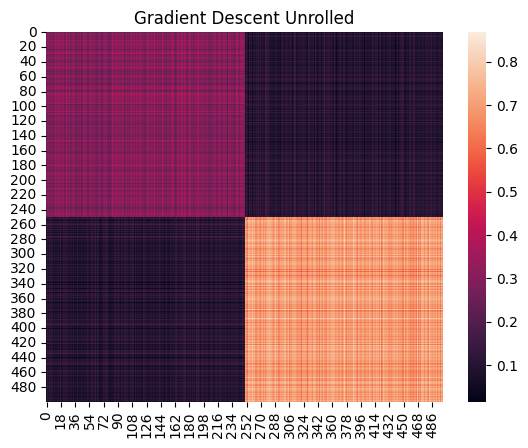

In [8]:
## 1000 layers == 1000 gd steps

gd_steps = 1000
in_channels = 2
out_channels = 2
alpha = 0.0001

model = GD_Unroll(in_channels, out_channels, gd_steps)

model.gd.gcn.lins[0].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha

model.gd.gat.lin1.weight.data = torch.Tensor([[0.0, 0.0], [0.0, 0.0]])
model.gd.gat.lin2.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha
model.gd.gat.lin3.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gat.lin4.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

with torch.no_grad():
    x_emb = model(data.x, data.edge_index, edge_index_2)

plt.figure()
sns.heatmap(x_emb[0,]@x_emb[0,].T)
plt.title('Gradient Descent Unrolled')

print("Loss:", torch.norm(x_emb[0,]@x_emb[0,].T - pyg.utils.to_dense_adj(edge_index).squeeze()).numpy())


Loss: 193.39847


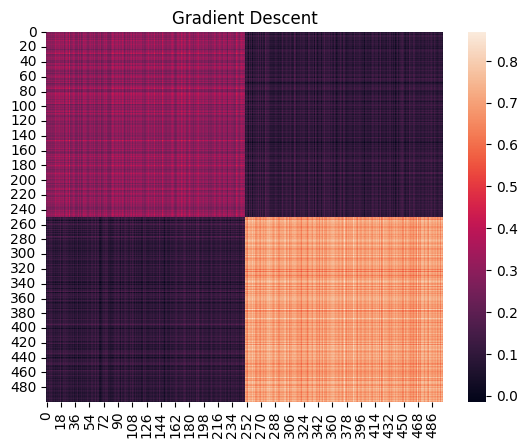

In [9]:
x_new=data.x

for i in range(1000):
    grad_f=4*(x_new[0,]@x_new[0,].T-pyg.utils.to_dense_adj(edge_index).squeeze())@x_new[0,]
    x_new=x_new-alpha*grad_f

plt.figure()
sns.heatmap(x_new[0,]@x_new[0,].T)
plt.title('Gradient Descent')

print("Loss:", torch.norm(x_new[0,]@x_new[0,].T - pyg.utils.to_dense_adj(edge_index).squeeze()).numpy())

### Forward pass with many nodes and SBM graph with same probabily intra-community

In [43]:
gd_steps = 20
in_channels = 2
out_channels = 2

model = GD_Unroll(in_channels, out_channels, gd_steps)

""" model.gd.gcn.lins[0].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha

model.gd.gat.lin1.weight.data = torch.Tensor([[0.0, 0.0], [0.0, 0.0]])
model.gd.gat.lin2.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*4*alpha
model.gd.gat.lin3.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gat.lin4.weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]]) """

# Initialize weights
model.gd.gcn.lins[0].weight.data = torch.nn.init.xavier_uniform_(model.gd.gcn.lins[0].weight)
model.gd.gcn.lins[1].weight.data = model.gd.gcn.lins[1].weight.data*0.0001
model.gd.gat.W_2.data = torch.nn.init.xavier_uniform_(model.gd.gat.W_2)*0.0001
model.gd.gat.W_3.data = torch.nn.init.xavier_uniform_(model.gd.gat.W_3)

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0729, -0.0499],
        [-1.2142, -0.6732]], requires_grad=True)
Parameter containing:
tensor([[-6.5528e-06, -4.1378e-05],
        [-5.2889e-05, -3.4402e-05]], requires_grad=True)
Parameter containing:
tensor([[-4.2284e-05, -1.2706e-04]], requires_grad=True)
Parameter containing:
tensor([[ 0.3657, -0.9684]], requires_grad=True)


Loss: 273.82364
Loss: 205.08975


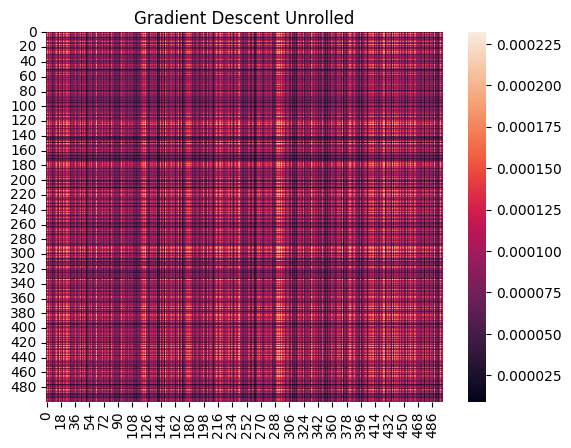

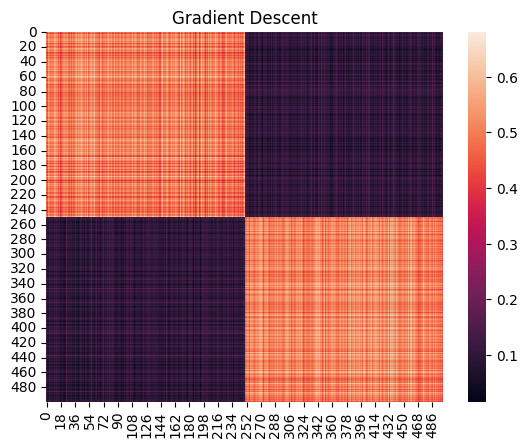

In [44]:
# Initialize weights
""" model.gd.gcn.lins[0].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])
model.gd.gcn.lins[1].weight.data = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])*0.001
model.gd.gat.W_2.data = torch.Tensor([[1.0, 1.0]])*0.001
model.gd.gat.W_3.data = torch.Tensor([[1.0, 1.0]]) """

num_nodes = 500
n_components = 2 

n = [num_nodes/2, num_nodes/2]
p = [[0.5, 0.1], [0.1, 0.5]]

edge_index = pyg.utils.stochastic_blockmodel_graph(n, p)

x = torch.rand((1, num_nodes,2))

data = pyg.data.Data(x = x, edge_index = edge_index)

## 1000 layers == 1000 gd steps


alpha=0.0001

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

with torch.no_grad():
    x_emb = model(data.x, data.edge_index, edge_index_2)

plt.figure()
sns.heatmap(x_emb[0,]@x_emb[0,].T)
plt.title('Gradient Descent Unrolled')

print("Loss:", torch.norm(x_emb[0,]@x_emb[0,].T - pyg.utils.to_dense_adj(edge_index).squeeze()).numpy())


x_new=data.x

for i in range(1000):
    grad_f=4*(x_new[0,]@x_new[0,].T-pyg.utils.to_dense_adj(edge_index).squeeze())@x_new[0,]
    x_new=x_new-alpha*grad_f

plt.figure()
sns.heatmap(x_new[0,]@x_new[0,].T)
plt.title('Gradient Descent')

print("Loss:", torch.norm(x_new[0,]@x_new[0,].T - pyg.utils.to_dense_adj(edge_index).squeeze()).numpy())
